In [1]:
import os,time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_desc_pth = '/kaggle/input/gemstone-price-prediction/Data Dictionary.xlsx'
orig_data_pth = '/kaggle/input/gemstone-price-prediction/cubic_zirconia.csv'
train_pth = '/kaggle/input/playground-series-s3e8/train.csv'
test_pth = '/kaggle/input/playground-series-s3e8/test.csv'

In [3]:
train_df = pd.read_csv(train_pth)
train_df['is_original'] = 0
print(train_df.dtypes)
train_df.head()

id               int64
carat          float64
cut             object
color           object
clarity         object
depth          float64
table          float64
x              float64
y              float64
z              float64
price            int64
is_original      int64
dtype: object


,id,carat,cut,color,clarity,depth,table,x,y,z,price,is_original
0,0,1.52,Premium,F,VS2,62.2,58.0,7.27,7.33,4.55,13619,0
1,1,2.03,Very Good,J,SI2,62.0,58.0,8.06,8.12,5.05,13387,0
2,2,0.70,Ideal,G,VS1,61.2,57.0,5.69,5.73,3.50,2772,0
3,3,0.32,Ideal,G,VS1,61.6,56.0,4.38,4.41,2.71,666,0
4,4,1.70,Premium,G,VS2,62.6,59.0,7.65,7.61,4.77,14453,0


In [4]:
orig_df = pd.read_csv(orig_data_pth)
orig_df['is_original'] = 1
orig_df = orig_df.drop('Unnamed: 0',axis=1)
print(orig_df.dtypes)

carat          float64
cut             object
color           object
clarity         object
depth          float64
table          float64
x              float64
y              float64
z              float64
price            int64
is_original      int64
dtype: object


In [5]:
pd.options.display.max_colwidth=250
desc = pd.read_excel(data_desc_pth)
desc

,Variable Name,Description
0,Carat,Carat weight of the cubic zirconia.
1,Cut,"Describe the cut quality of the cubic zirconia. Quality is increasing order Fair, Good, Very Good, Premium, Ideal."
2,Color,Colour of the cubic zirconia.With D being the best and J the worst.
3,Clarity,"cubic zirconia Clarity refers to the absence of the Inclusions and Blemishes. (In order from Best to Worst, FL = flawless, I3= level 3 inclusions) FL, IF, VVS1, VVS2, VS1, VS2, SI1, SI2, I1, I2, I3"
4,Depth,"The Height of a cubic zirconia, measured from the Culet to the table, divided by its average Girdle Diameter."
5,Table,The Width of the cubic zirconia's Table expressed as a Percentage of its Average Diameter.
6,Price,the Price of the cubic zirconia.
7,X,Length of the cubic zirconia in mm.
8,Y,Width of the cubic zirconia in mm.
9,Z,Height of the cubic zirconia in mm.


In [6]:
all_data = pd.concat([train_df,orig_df],axis=0)
all_data = all_data.drop_duplicates()
print(all_data.shape)
print(all_data.isna().sum())

(220506, 12)
id             26933
carat              0
cut                0
color              0
clarity            0
depth            697
table              0
x                  0
y                  0
z                  0
price              0
is_original        0
dtype: int64


In [7]:
all_data['depth'] = all_data['depth'].fillna(all_data['depth'].median())

In [8]:
def get_outliers(col,df,a = 4.0):
    m_ = df[col].mean()
    s_ = df[col].std()
    up_lim = m_ + a*s_
    low_lim = m_ - a*s_
    outs = ((df[col] < low_lim) | (df[col] > up_lim))
    return outs



def get_outliers_all(df,cols_list,a=3.0,remove_outs=False):
    proc_df = df.copy(deep=True)
    for col in cols_list:
        outs = get_outliers(col,proc_df,a=a)
        out_count = sum(outs)
        print(f'{col} : {out_count}')
        if remove_outs:
            if out_count > 0:
                print(f'Removing outs from : {col}')
                proc_df = proc_df[outs == False]
    return proc_df

def replace_cate(data_:pd.DataFrame):
    data = data_.copy(deep=True)
    cut_uniq_vals = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
    cut_dict_ = {v:1.2**i for i,v in enumerate(cut_uniq_vals)}
    color_vals = ['J','I','H','G','F','E','D']
    color_dict_ = {v:1.25**i for i,v in enumerate(color_vals)}
    clarity_vals = ['I3', 'I2', 'I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF', 'FL']
    clarity_dict_ = {v:1.25**i for i,v in enumerate(clarity_vals)}
    data['cut'] = data['cut'].map(cut_dict_)
    data['color'] = data['color'].map(color_dict_)
    data['clarity'] = data['clarity'].map(clarity_dict_)
    return data

# def preprocess_(data_:pd.DataFrame,num_cols:[str]):
#     data = data_.copy(deep=True)
#     data = replace_cate(data)
#     data = get_outliers_all(data,num_cols,remove_outs=True)
#     return data

all_df = replace_cate(all_data)
print(all_df.shape)
_ = get_outliers_all(all_df,['carat', 'depth', 'table', 'x', 'y','z'],a=4.0,remove_outs=True)

(220506, 12)
carat : 56
Removing outs from : carat
depth : 627
Removing outs from : depth
table : 247
Removing outs from : table
x : 4
Removing outs from : x
y : 1
Removing outs from : y
z : 18
Removing outs from : z


In [9]:
all_df.dtypes

id             float64
carat          float64
cut            float64
color          float64
clarity        float64
depth          float64
table          float64
x              float64
y              float64
z              float64
price            int64
is_original      int64
dtype: object

In [10]:
feat_cols = ['carat', 'depth', 'table', 'x', 'y','z','cut','color','clarity']
target_col = 'price'

X = all_df[feat_cols].values
y = all_df[target_col].values
print(X.shape,y.shape)

(220506, 9) (220506,)


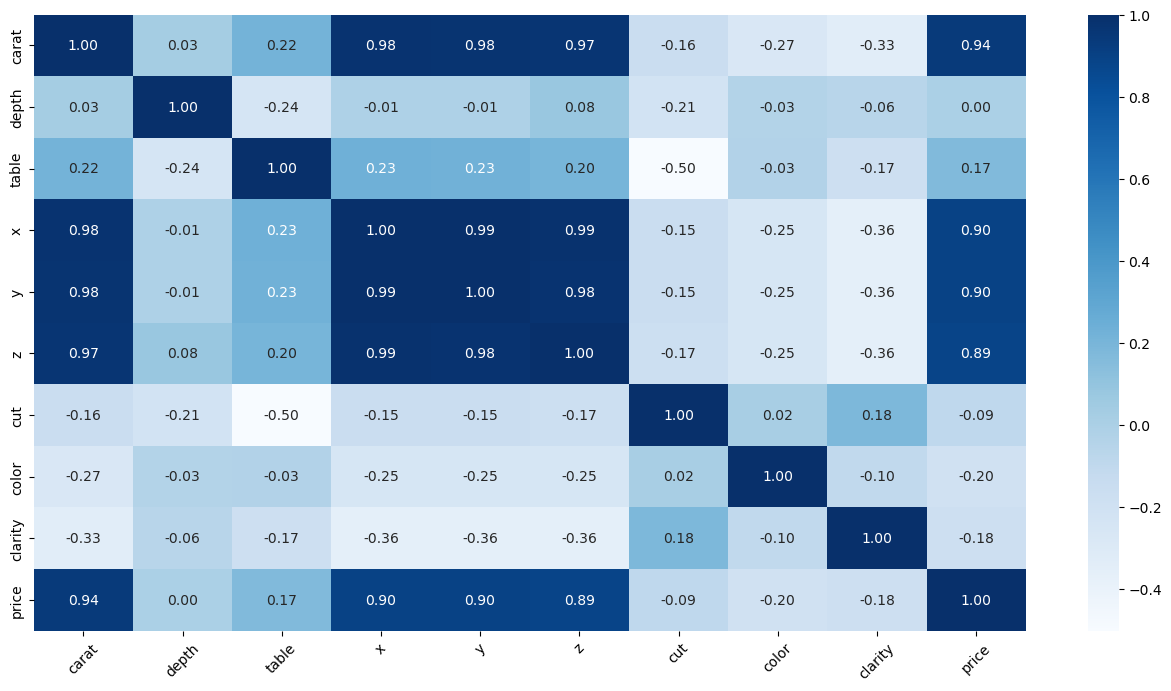

In [11]:
corr = all_df[feat_cols+[target_col]].corr()
fig = plt.figure(figsize=(16,8))
sns.heatmap(corr,annot=True,fmt='.2f',cmap='Blues')
plt.xticks(rotation=45);

In [12]:
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error
import math
import optuna

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.2)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(176404, 9) (176404,)
(44102, 9) (44102,)


In [16]:
def objective(trial):
    learning_rate_ = trial.suggest_float("learning_rate",0.01,0.5),
    num_leaves_ = trial.suggest_int('num_leaves',20,60)
    max_depth_ = trial.suggest_int('max_depth',5,10),
    n_estimators_ = trial.suggest_int('n_estimators',1000,10000)
    
    
    lgb_r = LGBMRegressor(
        max_depth=max_depth_,
        num_leaves=num_leaves_,n_estimators=n_estimators_,
        learning_rate=learning_rate_
    )
    
    scores = cross_val_score(lgb_r,X_train,y_train,scoring='neg_root_mean_squared_error',cv=5)
    rmse_m = scores.mean()
    return rmse_m

In [17]:
study = optuna.create_study(
    direction='maximize',
    sampler = optuna.samplers.RandomSampler()
)

study.optimize(objective,n_trials=10)

[I 2023-03-06 18:03:38,355] A new study created in memory with name: no-name-2a42940f-b136-4ef9-9777-ad2c53ed70a8
[I 2023-03-06 18:05:14,638] Trial 0 finished with value: -599.80111994709 and parameters: {'learning_rate': 0.11674313417447221, 'num_leaves': 49, 'max_depth': 10, 'n_estimators': 1611}. Best is trial 0 with value: -599.80111994709.
[I 2023-03-06 18:06:29,973] Trial 1 finished with value: -644.4435280881954 and parameters: {'learning_rate': 0.44377915178168775, 'num_leaves': 28, 'max_depth': 7, 'n_estimators': 1763}. Best is trial 0 with value: -599.80111994709.
[I 2023-03-06 18:12:51,153] Trial 2 finished with value: -610.0579470352457 and parameters: {'learning_rate': 0.05715247308117393, 'num_leaves': 34, 'max_depth': 9, 'n_estimators': 7855}. Best is trial 0 with value: -599.80111994709.
[I 2023-03-06 18:16:32,064] Trial 3 finished with value: -578.6601785678757 and parameters: {'learning_rate': 0.02344387017436962, 'num_leaves': 22, 'max_depth': 7, 'n_estimators': 5610

In [ ]:
## best params : 'learning_rate': 0.02344387017436962, 'num_leaves': 22, 'max_depth': 7, 'n_estimators': 5610}

In [23]:
datasets = []

kfold = KFold(n_splits =10,shuffle=True,random_state=10)
for tr_split,te_split in kfold.split(X_scaled):
    train_X,test_X = X_scaled[tr_split,:],X_scaled[te_split,:]
    train_y,test_y = y[tr_split],y[te_split]
    print(f'Fold : {len(datasets)}, train : {train_X.shape,train_y.shape}, test : {test_X.shape,test_y.shape}')
    datasets.append({'train' : [train_X,train_y],'test':[test_X,test_y]})

Fold : 0, train : ((198455, 9), (198455,)), test : ((22051, 9), (22051,))
Fold : 1, train : ((198455, 9), (198455,)), test : ((22051, 9), (22051,))
Fold : 2, train : ((198455, 9), (198455,)), test : ((22051, 9), (22051,))
Fold : 3, train : ((198455, 9), (198455,)), test : ((22051, 9), (22051,))
Fold : 4, train : ((198455, 9), (198455,)), test : ((22051, 9), (22051,))
Fold : 5, train : ((198455, 9), (198455,)), test : ((22051, 9), (22051,))
Fold : 6, train : ((198456, 9), (198456,)), test : ((22050, 9), (22050,))
Fold : 7, train : ((198456, 9), (198456,)), test : ((22050, 9), (22050,))
Fold : 8, train : ((198456, 9), (198456,)), test : ((22050, 9), (22050,))
Fold : 9, train : ((198456, 9), (198456,)), test : ((22050, 9), (22050,))


In [24]:
test_df = pd.read_csv(test_pth)
test_df = replace_cate(test_df)
test_df['is_original'] = 0
test_df = scaler.transform(test_df[feat_cols].values)

In [25]:
err_list = []
fi_list = []
test_preds_list = []

for i,d_ in enumerate(datasets):
    train_X,train_y = d_['train']
    test_X,test_y = d_['test']
    
    model = LGBMRegressor(learning_rate=0.02344387017436962, num_leaves=22, max_depth= 7, n_estimators=5610)
    model.fit(train_X,train_y)
    train_preds = model.predict(train_X)
    train_err = math.sqrt(mean_squared_error(train_y,train_preds))
    test_preds = model.predict(test_X)
    err = math.sqrt(mean_squared_error(test_y,test_preds))
    err_list.append(err)
    print(f'Fold : {i}, train err : {train_err} test error : {err}')
    fi = model.feature_importances_
    fi_list.append(fi)
    
    preds_ = model.predict(test_df)
    test_preds_list.append(preds_)

Fold : 0, train err : 496.1544657093851 test error : 575.6136064587658
Fold : 1, train err : 494.60288445748097 test error : 588.5758451264021
Fold : 2, train err : 496.4626119278574 test error : 566.0805318714116
Fold : 3, train err : 496.67008162005743 test error : 570.2580332746196
Fold : 4, train err : 495.86454909437225 test error : 581.4588489007381
Fold : 5, train err : 493.68982005025777 test error : 600.0434101126209
Fold : 6, train err : 497.12521856049887 test error : 564.101676311352
Fold : 7, train err : 497.6368323171493 test error : 570.8140882625753
Fold : 8, train err : 495.09229421566965 test error : 569.1178409947582
Fold : 9, train err : 494.3610718379592 test error : 588.2005461723521


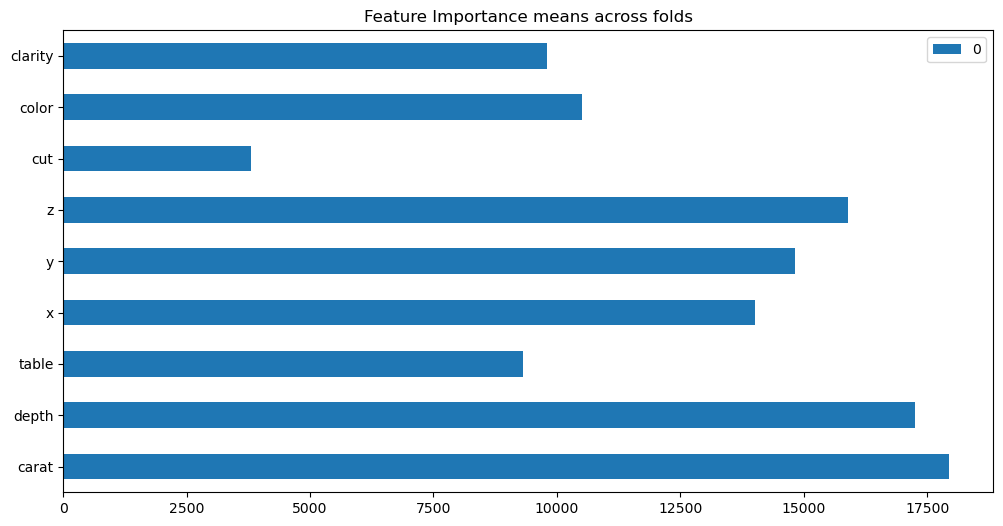

In [26]:
fis_f = np.array(fi_list).mean(axis=0)
pd.DataFrame(fis_f,index=feat_cols,columns=['0']).plot(kind='barh',figsize=(12, 6),title='Feature Importance means across folds');

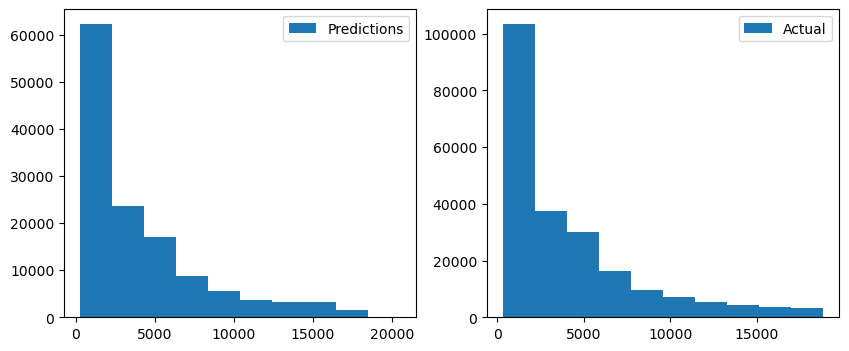

In [27]:
preds_f = np.array(test_preds_list).mean(axis=0)
_,(ax1,ax2) = plt.subplots(1,2,figsize = (10,4))
ax1.hist(preds_f,label='Predictions')
ax1.legend()
ax2.hist(all_df['price'].values,label='Actual')
ax2.legend()

In [28]:
def create_sub(preds,sub_no=1):
    test_df = pd.read_csv(test_pth)
    test_df['price'] = preds
    subs = test_df[['id','price']]
    subs.to_csv('/kaggle/working/submissions_{}.csv'.format(sub_no),index=False)
    print('Predictions saved to submissions_{}.csv'.format(sub_no))
    return subs

In [29]:
subs = create_sub(preds_f,sub_no=3)
subs.head()

Predictions saved to submissions_3.csv


,id,price
0,193573,859.113422
1,193574,2534.810734
2,193575,2299.578893
3,193576,871.684010
4,193577,5742.309193
